In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
pd.set_option("display.max_columns", None)

import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from torch.distributions import Categorical
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [4]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)




Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15738908.28it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 496185.27it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3550319.69it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10793500.72it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [128]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)
# Iterate through the dataloader to access batches
for batch_idx, (X, y) in enumerate(train_dataloader):
    if batch_idx == 0:  # Print shape of the first batch
        print(X.shape)
        break  # Stop after the first batch

print(len(train_dataloader))
print(len(test_dataloader))

torch.Size([64, 1, 28, 28])
938
157


Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


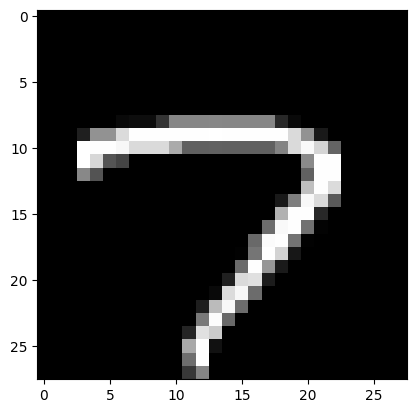

Label: 7
cpu


In [5]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[1].squeeze()
label = train_labels[1]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")
print(train_features.device)

In [26]:
from torch import nn
class Digit(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

In [27]:
Digits = Digit(input_shape=784, hidden_units=256, output_shape=256).to(device)


In [36]:
print(next(Digits.parameters()).device) # Access device of a model parameter

cuda:0


In [29]:
MseLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Digits.parameters(), lr=0.01)



In [30]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [31]:
# Import accuracy metric
from helper_functions import accuracy_fn # Note: could also use torchmetrics.Accuracy(task = 'multiclass', num_classes=len(class_names)).to(device)


In [32]:
# Import tqdm for progress bar

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 15

# Create training and testing loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        Digits.train()
        # 1. Forward pass
        y_logits = Digits(X)

        # 2. Calculate loss (per batch)
        loss = MseLoss(y_logits, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    Digits.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_logits = Digits(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1).to(device)
            # 2. Calculate loss (accumatively)
            test_loss += MseLoss(test_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


Epoch: 0
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.25332 | Test loss: 0.15693, Test acc: 95.27%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.13156 | Test loss: 0.13567, Test acc: 96.13%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.12053 | Test loss: 0.15344, Test acc: 95.83%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.10067 | Test loss: 0.12848, Test acc: 96.69%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.09910 | Test loss: 0.13264, Test acc: 96.71%

Epoch: 5
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.09023 | Test loss: 0.19064, Test acc: 95.89%

Epoch: 6
-------

In [91]:
#Saving the model

digits_path = "digits.pth"
torch.save(obj=Digits.state_dict(), f=digits_path)


In [34]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (5 - five)


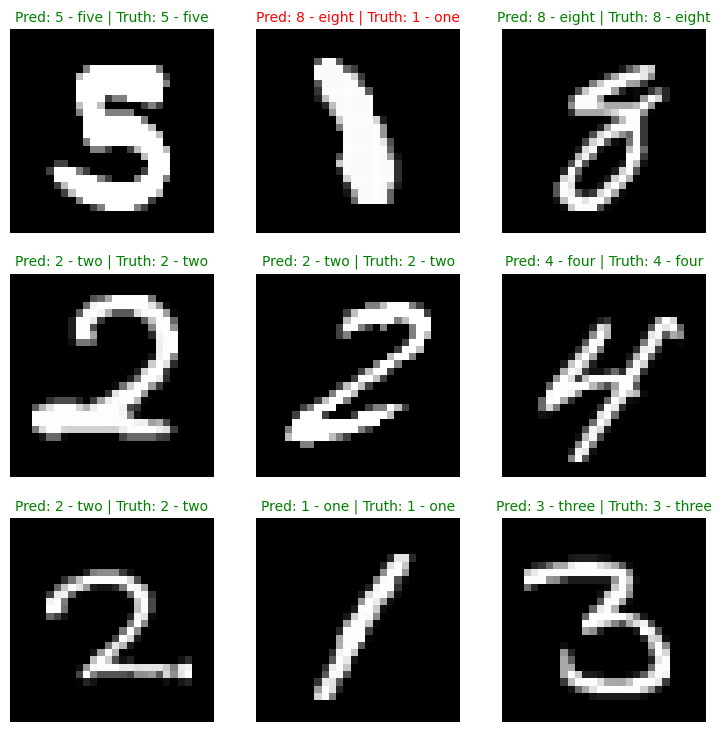

In [35]:
import random
classe_names = train_data.classes
#print(classe_names)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classe_names[test_labels[0]]})")




pred_classes = make_predictions(Digits, test_samples).argmax(dim=1)


# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classe_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classe_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

# Using CNN


In [45]:
# Create a convolutional neural network
class DigitV2(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = DigitV2(input_shape=1,
    hidden_units=10,
    output_shape=10).to(device)
model_2

DigitV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [46]:
print(next(model_2.parameters()).device) # Access device of a model parameter

cuda:0


In [47]:
MseLoss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)



In [49]:

# Set the seed and start the timer
torch.manual_seed(42)

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 5

# Create training and testing loop
for epoch in range(epochs):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        model_2.train()
        # 1. Forward pass
        y_logits = model_2(X)

        # 2. Calculate loss (per batch)
        loss = MseLoss(y_logits, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_2.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_logits = model_2(X)
            test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1).to(device)
            # 2. Calculate loss (accumatively)
            test_loss += MseLoss(test_logits, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred)

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


Epoch: 0
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.04415 | Test loss: 0.05369, Test acc: 98.15%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.04061 | Test loss: 0.04017, Test acc: 98.64%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.03615 | Test loss: 0.04369, Test acc: 98.46%

Epoch: 3
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.03207 | Test loss: 0.04265, Test acc: 98.73%

Epoch: 4
-------
Looked at 0/60000 samples
Looked at 25600/60000 samples
Looked at 51200/60000 samples

Train loss: 0.03107 | Test loss: 0.03497, Test acc: 98.91%



Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 0 (0 - zero)


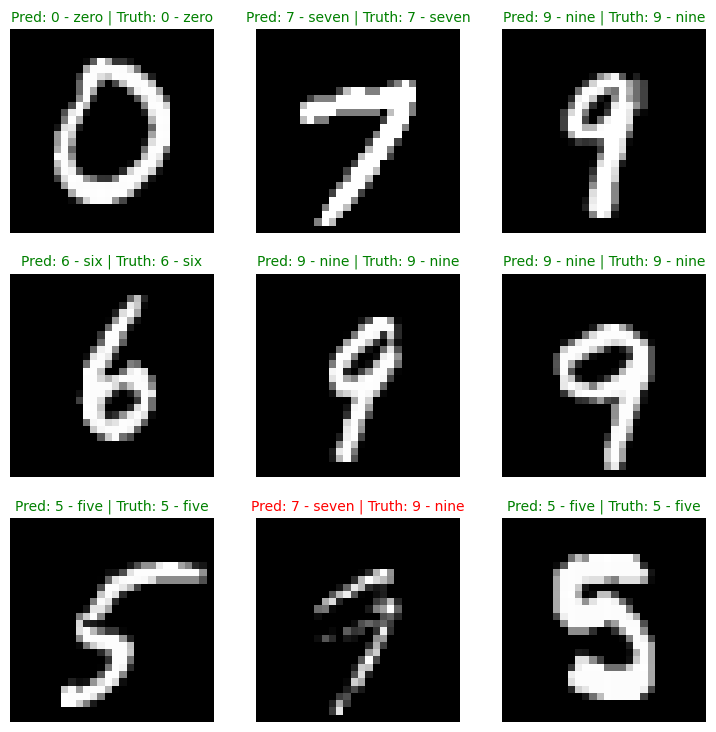

In [124]:
import random
classe_names = train_data.classes
#print(classe_names)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classe_names[test_labels[0]]})")




pred_classes = make_predictions(model_2, test_samples).argmax(dim=1)


# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "nine")
  pred_label = classe_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "seven")
  truth_label = classe_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);